In [4]:
# import QuTiP
from qutip import *
import matplotlib.pyplot as plt

# define identity for qubits 
I2 = qeye(2)

# define Pauli matrices and constants
σ_x = sigmax()
σ_y = sigmay()
σ_z = sigmaz()
π = np.pi

$$ 
\begin{align}
    \Large \mathcal{D}_B(\alpha, \lambda, E_n) &= \Large  \prod_{j=1}^{\lceil \frac{N - 1}{2} \rceil} \mathcal{D}_{XYZ}^{ \left(2j - 1 \right)}\left(\alpha, \lambda, E_n \right) \\
    \Large \mathcal{D}_R(\alpha, \lambda, E_n) &= \Large \prod_{j=1}^{\lfloor \frac{N - 1}{2} \rfloor} \mathcal{D}_{XYZ}^{ \left(2j \right)}\left(\alpha, \lambda, E_n \right)
\end{align}
$$

In [29]:
def Dxyz(N, cutoff, α, λ, E_n):
    
    # define annihilation operator according to Fock space
    a = destroy(cutoff)
    Ib = qeye(cutoff)
    
    # displacement operator on cavity 1 which there are only two sites 
    if N == 2:
        cavity_subsystem = tensor(α*a.dag() - np.conj(α)*a)
        qubit_subsystem = tensor(σ_x, σ_x) + tensor(σ_y, σ_y) + λ*tensor(σ_z, σ_z) - E_n*tensor(I2, I2)
        
    # displacement operator on cavity 2 which there are three sites sites
    elif N == 3: 
        cavity_subsystem = tensor(α*a.dag() - np.conj(α)*a, Ib)
        qubit_subsystem = tensor(σ_x, σ_x, I2) + tensor(σ_y, σ_y, I2) + λ*tensor(σ_z, σ_z, I2) - E_n*tensor(I2, I2, I2)
        
    return (tensor(cavity_subsystem, qubit_subsystem)).expm()
def ground_state_projection(N, cutoff, num_states, λ, E_n, α_start, α_end, steps, singlet):

    # define operators for bosonic modes 
    a = destroy(cutoff)
    Ib = identity(cutoff)

    # define vacuum state for a cavity, and spin up and spin down states for qubits
    vacuum = basis(cutoff, 0)
    up = basis(2,0)
    down = basis(2,1)

    # define array over which we will sweep α
    α_array = np.linspace(α_start, α_end, steps)

    # with both cavities in vacuum, define initial state that is a random two-qubit state;
    # for sanity check, also define singlet state with both cavities in vacuum
    # initial_state = (tensor(vacuum, rand_ket(2), rand_ket(2))).unit()
    initial_state_list = [(tensor(vacuum, rand_ket(2), rand_ket(2))).unit() for state in range(num_states)]

    # define a singlet state and a density matrix for a singlet state
    singlet_state = (tensor(up, down) - tensor(down, up)).unit()
    ρ_singlet_state = singlet_state*singlet_state.dag()

    # define projection operator that projects the first cavity onto the vacuum
    P = tensor(vacuum*vacuum.dag(), I2, I2)

    projection_fidelity_list = [[fidelity(ρ_singlet_state, ((P*Dxyz(N, cutoff, α, λ, E_n)*initial_state).unit()).ptrace([1,2])) \
                                 for α in α_array] for initial_state in initial_state_list]
    
    # create plot 
    fig, ax = plt.subplots(figsize=(8, 6))

    # # graph the projection of all initial states onto the singlet 
    for i, projection in enumerate(projection_fidelity_list): 
        ax.plot(α_array, projection, label=f'Inital Fidelity {projection[0] : .3f}')
        
    # plot ground state projection overlap with singlet as initial state
    if singlet == True:
        initial_state_singlet = (tensor(vacuum, up, down) - tensor(vacuum, down, up)).unit()
        
        singlet_projection = [fidelity(ρ_singlet_state, ((P*Dxyz(N, cutoff, α, λ, E_n)*initial_state_singlet).unit()).ptrace([1,2])) \
                                 for α in α_array]
        
        # plot projection onto singlet with singlet as initial state
        ax.plot(α_array, singlet_projection, label = 'Singlet')

    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel('Fidelity')
    ax.set_title('Singlet Projection Fidelity')
    ax.legend()
    ax.grid(True)

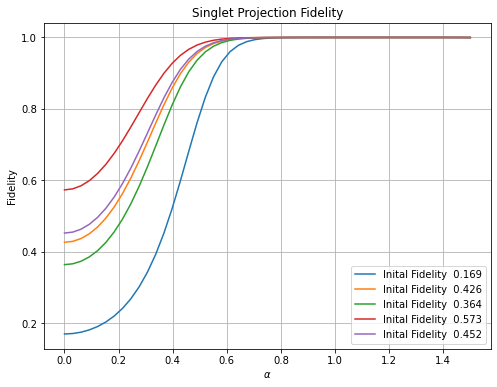

In [35]:
# define parameters for ground state 
N = 2
cutoff = 20
num_states = 5
λ = 1
E_n = -3
α_start = 0
α_end = 1.5
steps = 50

ground_state_projection(N, cutoff, num_states, λ, E_n, α_start, α_end, steps, singlet = False)

$$ 
\begin{align}
    \Large \mathcal{D}_B(\alpha, \lambda, E_n) &= \Large  \prod_{j=1}^{\lceil \frac{N - 1}{2} \rceil} \mathcal{D}_{XYZ}^{ \left(2j - 1 \right)}\left(\alpha, \lambda, E_n \right) \\
    \Large \mathcal{D}_R(\alpha, \lambda, E_n) &= \Large \prod_{j=1}^{\lfloor \frac{N - 1}{2} \rfloor} \mathcal{D}_{XYZ}^{ \left(2j \right)}\left(\alpha, \lambda, E_n \right)
\end{align}
$$

In [22]:
# function to generate H_blue and H_red for a lattice of N_sites
def trotterize_alternate_bonds(N, M, θ, λ):

    # define emtpy list 
    Rxyz_list = []

    for i in range(N):
        
        # define iterator that begins at 1 and ends at N
        j = i + 1
        
        # create Rxyz_list such that Rxyz_list[j] is applies Rxyz to the bond
        # connecting jth and (j+1)th site
        if j < N:
            operator_list = [qeye(2)]*(N-1)
            operator_list[i] = (-1j*(2*α**2)*(tensor(σ_x,σ_x) + tensor(σ_y,σ_y) + λ*tensor(σ_z,σ_z))).expm()
            Rxyz_list.append(tensor(operator_list))
              
    if N == 2: 
        
        # yield an operator that applies Rxx(θ)*Ryy(θ)*Rzz(θ) to the blue bond in a 1D spin chain
        Rxyz_odd_sites = Rxyz_list[0]
        return Rxyz_odd_sites
    
    else: 
    
        # multiply all Rxyz operators acting on all odd lattice sites; this is an operator that applies
        # Rxx(θ)*Ryy(θ)*Rzz(θ) to all "blue bonds" in a 1D spin chain
        Rxyz_odd_sites = reduce(lambda x, y: x*y, [matrix for index, matrix in enumerate(Rxyz_list) if index % 2 == 0])

        # multiply all Rxyz operators acting on all even lattice sites; this is an operator that applies
        # Rxx(θ)*Ryy(θ)*Rzz(θ) to all "red bonds" in a 1D spin chain 
        Rxyz_even_sites = reduce(lambda x, y: x*y, [matrix for index, matrix in enumerate(Rxyz_list) if index % 2 != 0])
    
    # trotterize according to U ~ (R_blue *R_red)**M
    return (Rxyz_odd_sites*Rxyz_even_sites)**M

In [23]:
U_trotter = trotterize_alternate_bonds(N=2, M=10, θ=π/3, λ=1)
U_trotter

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0.98463154-0.17464461j 0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.92456756+0.16399103j 0.06006398-0.33863564j
  0.        +0.j        ]
 [0.        +0.j         0.06006398-0.33863564j 0.92456756+0.16399103j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.98463154-0.17464461j]]